FINAL SPARK ML GROUP A PROJECT


CHURN PREDICTION MODEL FOR TELECOMMUNICATIONS-
SPARK CLASSIFICATION

Business Case description:

Estimate the risk of churning to anticipate customers intention to cancel subscriptions

Industry: Telecommunications offering telephone and internet services

Actual churn rate: 27%

Objective: reduction up to 15% applying data mining and machine learning techniques


In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

LOAD DATA

In [2]:
# Create a SparkSession and specify configuration
spark = SparkSession \
    .builder \
    .appName("Final_Project_GroupA") \
    .getOrCreate()

In [3]:
# Load data
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv("file:///data/home/juan.dalessandro/Telco_Customer_Churn.csv")

Data description:
* Sample size: 7000
* Each row represents a customer and each column contains customers attributes (21 features)

In [4]:
df.cache()

DataFrame[customerID: string, gender: string, SeniorCitizen: int, Partner: string, Dependents: string, tenure: int, PhoneService: string, MultipleLines: string, InternetService: string, OnlineSecurity: string, OnlineBackup: string, DeviceProtection: string, TechSupport: string, StreamingTV: string, StreamingMovies: string, Contract: string, PaperlessBilling: string, PaymentMethod: string, MonthlyCharges: double, TotalCharges: double, Churn: string]

In [5]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



We double checked in the schema the type of each feature:
* Customer account information
* Demographics about the customers
* Services provided
* Targer feature of customers leaving in the last month (yes/no = boolean)

DATA INSPECTION

We use spark commands and sql statements to explore the datasets

In [6]:
df.select('TotalCharges').describe().show()

+-------+------------------+
|summary|      TotalCharges|
+-------+------------------+
|  count|              7032|
|   mean|2283.3004408418697|
| stddev| 2266.771361883145|
|    min|              18.8|
|    max|            8684.8|
+-------+------------------+



In [7]:
print('Nb. of Customers  : %d' % df.count())

Nb. of Customers  : 7043


In [8]:
df.groupby('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
|  Yes| 1869|
+-----+-----+



We can appreciate our dataset is unbalanced as expected. In Spark there´s no specific package to handle unbalanced datasets yet so we will use as our main algorithm: random forest (please check next steps: mainly cross validation) to overcome this problem

In [9]:
# work with Pandas just to have a quick look of the dataset for better comprenhension
pd_df=df.toPandas()
pd_df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [10]:
# On a different jupyter notebook we can have a complete analysis of the data and its description to dig better on it,
# as it is not the scope of this analysis we do not comment this chunk
# Import pandas profiling to obtain a complete exploratory data analysis
# import pandas_profiling
# profile = df.profile_report(title='FinalProject Report')
# profile.to_file(output_file="FinalProject_profile.html")
# df.profile_report(style={'full_width':True})

In [11]:
df.describe().toPandas().transpose()
# no missing values on the data set
# numeric features: tenure, MonthlyCharges, TotalCharges
# boolean: gender, SeniorCitizen, Partner, Dependents, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, PaperlessBilling
# string: MultipleLines, InternetSevice, Contract, PaymentMethod
# label: Churn should be 1/0 also. 

,0,1,2,3,4
summary,count,mean,stddev,min,max
customerID,7043,None,None,0002-ORFBO,9995-HOTOH
gender,7043,None,None,Female,Male
SeniorCitizen,7043,0.1621468124378816,0.3686116056100135,0,1
Partner,7043,None,None,No,Yes
Dependents,7043,None,None,No,Yes
tenure,7043,32.37114865824223,24.559481023094442,0,72
PhoneService,7043,None,None,No,Yes
MultipleLines,7043,None,None,No,Yes
InternetService,7043,None,None,DSL,No


We are dealing with categorical data, so we do take the necessary steps during the featuring enginnering

In [12]:
# create a temp table for SQL access. 
# run some SQL queries
df.createOrReplaceTempView("df_sql")
contract_yes = spark.sql("SELECT Contract as Churn, COUNT(Contract) FROM df_sql WHERE Churn = 'Yes' GROUP BY Contract ORDER BY COUNT(Contract) DESC").show()
contract_no = spark.sql("SELECT Contract as No_Churn, COUNT(Contract) FROM df_sql WHERE Churn = 'No' GROUP BY Contract ORDER BY COUNT(Contract) DESC").show()

+--------------+---------------+
|         Churn|count(Contract)|
+--------------+---------------+
|Month-to-month|           1655|
|      One year|            166|
|      Two year|             48|
+--------------+---------------+

+--------------+---------------+
|      No_Churn|count(Contract)|
+--------------+---------------+
|Month-to-month|           2220|
|      Two year|           1647|
|      One year|           1307|
+--------------+---------------+



In [13]:
df.select('MultipleLines').distinct().collect()

[Row(MultipleLines='No phone service'),
 Row(MultipleLines='No'),
 Row(MultipleLines='Yes')]

In [14]:
df.createOrReplaceTempView("df_sql2")
multiple_lines = spark.sql("SELECT MultipleLines, COUNT(Contract) FROM df_sql2 GROUP BY MultipleLines ORDER BY COUNT(Contract) DESC").show()

+----------------+---------------+
|   MultipleLines|count(Contract)|
+----------------+---------------+
|              No|           3390|
|             Yes|           2971|
|No phone service|            682|
+----------------+---------------+



In [15]:
df.select('InternetService').distinct().collect()

[Row(InternetService='Fiber optic'),
 Row(InternetService='No'),
 Row(InternetService='DSL')]

In [16]:
df.createOrReplaceTempView("df_sql3")
multiple_lines = spark.sql("SELECT InternetService, COUNT(Contract) FROM df_sql3 GROUP BY InternetService ORDER BY COUNT(Contract) DESC").show()

+---------------+---------------+
|InternetService|count(Contract)|
+---------------+---------------+
|    Fiber optic|           3096|
|            DSL|           2421|
|             No|           1526|
+---------------+---------------+



In [17]:
df.select('PaymentMethod').distinct().collect()

[Row(PaymentMethod='Credit card (automatic)'),
 Row(PaymentMethod='Mailed check'),
 Row(PaymentMethod='Bank transfer (automatic)'),
 Row(PaymentMethod='Electronic check')]

In [18]:
df.createOrReplaceTempView("df_sql4")
multiple_lines = spark.sql("SELECT PaymentMethod, COUNT(Contract) FROM df_sql4 GROUP BY PaymentMethod ORDER BY COUNT(Contract) DESC").show()

+--------------------+---------------+
|       PaymentMethod|count(Contract)|
+--------------------+---------------+
|    Electronic check|           2365|
|        Mailed check|           1612|
|Bank transfer (au...|           1544|
|Credit card (auto...|           1522|
+--------------------+---------------+



In [19]:
df.select('StreamingTv').distinct().collect()

[Row(StreamingTv='No'),
 Row(StreamingTv='Yes'),
 Row(StreamingTv='No internet service')]

In [20]:
df.createOrReplaceTempView("df_sql5")
multiple_lines = spark.sql("SELECT StreamingTv, COUNT(Contract) FROM df_sql5 GROUP BY StreamingTv ORDER BY COUNT(Contract) DESC").show()

+-------------------+---------------+
|        StreamingTv|count(Contract)|
+-------------------+---------------+
|                 No|           2810|
|                Yes|           2707|
|No internet service|           1526|
+-------------------+---------------+



In our overall analysis we can appreciate: there are more month to month contracts, without multiple lines with internet services and not having as a mayority sreaming tv and where automatic payments is the chosen method

In [21]:
# Do some plots : for example , age distribution
import matplotlib.pyplot as plt
import seaborn as sns
x=df.select('tenure').collect()
ax=sns.distplot(x,bins=10)
ax.set_xlabel('tenure')
ax.set_ylabel('Normalized Counts')
ax.set_title('Months with the Company')
plt.show()

<Figure size 640x480 with 1 Axes>

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


Text(0, 0.5, 'Customers')

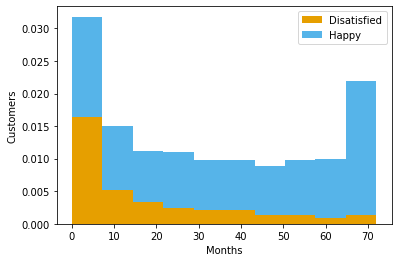

In [22]:
# Stacked histogram with Churn
# we will do it with pandas so that we do not have to create new files in Spark
x1 = list(pd_df[pd_df['Churn'] == 'Yes']['tenure'])
x2 = list(pd_df[pd_df['Churn'] == 'No']['tenure'])

colors = ['#E69F00', '#56B4E9']
names = ['Disatisfied', 'Happy']

plt.hist([x1, x2], bins = 10, stacked=True,
         normed=True, color = colors, label=names)
plt.legend()
plt.xlabel('Months')
plt.ylabel('Customers')

The mayority of dissatisfied customers and therefore more willing to churn have a contract relationship lower than 12 months

/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib64/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


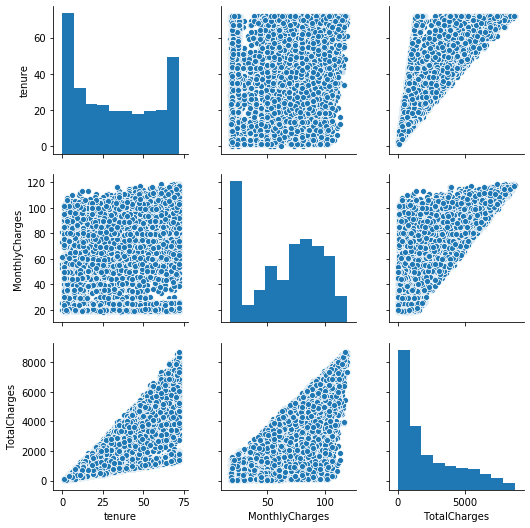

In [23]:
# Visualize 
import matplotlib.pyplot as plt
import seaborn as sns
numericCols = ['tenure', 'MonthlyCharges','TotalCharges']
sns.pairplot(pd_df[numericCols], dropna=True)

In [24]:
# checlking duplicate rows in the dataset
d = pd_df.drop_duplicates(subset=None, keep='first', inplace=False)

In [25]:
# we check again the shape to make sure if there were duplicate rows (not in this case)
d.shape

(7043, 21)

In [26]:
#check outliers
from pandas.api.types import is_numeric_dtype
def remove_outlier(pd_df):
    low = .05
    high = .95
    quant_pd_df = pd_df.quantile([low, high])
    for name in list(pd_df.columns):
        if is_numeric_dtype(pd_df[name]):
            pd_df = pd_df[(pd_df[name] > quant_pd_df.loc[low, name]) 
            & (pd_df[name] < quant_pd_df.loc[high, name])]
    return pd_df
remove_outlier(pd_df).head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


The dataset provided had not a bad quality so we did not need to do any preprocessing analysis

FEATURE TRANSFORMATION

In [28]:
# build the ML Pipeline
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer

We are working mainly with categorical data, so first step would be to transform these features into numercial ones using the OneHotEncoder

In [29]:
# cat features to numbers
categoricalColumns = ["MultipleLines", "InternetService", "Contract", "PaymentMethod", "gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "PaperlessBilling"]

stages = [] 
for col in categoricalColumns:
    # Category Indexing with StringIndexer
    indexer = StringIndexer(inputCol=col, outputCol=col+"Index")
    encoder = OneHotEncoder(inputCol=col+"Index", outputCol=col+"Vector")
    stages += [indexer,encoder]

In [30]:
n=0
for s in stages:
    print('stage number %d %s' %(n,s.getOutputCol()))
    n+=1     

stage number 0 MultipleLinesIndex
stage number 1 MultipleLinesVector
stage number 2 InternetServiceIndex
stage number 3 InternetServiceVector
stage number 4 ContractIndex
stage number 5 ContractVector
stage number 6 PaymentMethodIndex
stage number 7 PaymentMethodVector
stage number 8 genderIndex
stage number 9 genderVector
stage number 10 SeniorCitizenIndex
stage number 11 SeniorCitizenVector
stage number 12 PartnerIndex
stage number 13 PartnerVector
stage number 14 DependentsIndex
stage number 15 DependentsVector
stage number 16 PhoneServiceIndex
stage number 17 PhoneServiceVector
stage number 18 OnlineSecurityIndex
stage number 19 OnlineSecurityVector
stage number 20 OnlineBackupIndex
stage number 21 OnlineBackupVector
stage number 22 DeviceProtectionIndex
stage number 23 DeviceProtectionVector
stage number 24 TechSupportIndex
stage number 25 TechSupportVector
stage number 26 StreamingTVIndex
stage number 27 StreamingTVVector
stage number 28 StreamingMoviesIndex
stage number 29 Strea

In [31]:
# Use StringIndexer to encode ALSO our target (Churn) to label indices.
# Convert label into label indices using the StringIndexer
target_string = StringIndexer(inputCol = "Churn", outputCol = "label")
stages += [target_string]

In [32]:
# we execute the pipeline with all the stages previously created.
pipe = Pipeline(stages=stages)
engineering = pipe.fit(df)
final_df = engineering.transform(df)

In [33]:
# just to visualize the final dataset before doing the partition in training and testing
pd_final_df=final_df.toPandas()
pd_final_df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtectionVector,TechSupportIndex,TechSupportVector,StreamingTVIndex,StreamingTVVector,StreamingMoviesIndex,StreamingMoviesVector,PaperlessBillingIndex,PaperlessBillingVector,label
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,(1.0),0.0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,"(0.0, 1.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",1.0,(0.0),0.0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,(1.0),1.0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,"(0.0, 1.0)",1.0,"(0.0, 1.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",1.0,(0.0),0.0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,(1.0),1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,"(0.0, 1.0)",1.0,"(0.0, 1.0)",1.0,"(0.0, 1.0)",1.0,"(0.0, 1.0)",0.0,(1.0),0.0
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,"(0.0, 1.0)",0.0,"(1.0, 0.0)",1.0,"(0.0, 1.0)",1.0,"(0.0, 1.0)",0.0,(1.0),0.0
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,(1.0),0.0
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,"(1.0, 0.0)",0.0,(1.0),1.0


In [34]:
# we check again the structure of the dataset to see if the nuew features are there avoiding pandas commands
final_df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)
 |-- MultipleLinesIndex: double (nullable = false)
 |-- MultipleLinesVector: vecto

an alternative is to remove those features that are not going to be used ( for the final model we do not consider this dropping)


In [35]:
data = final_df.drop("customerID","gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity","OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod", "TotalCharges", "Churn", "MultipleLinesIndex", "InternetServiceIndex", "ContractIndex", "PaymentMethodIndex", "genderIndex", "SeniorCitizenIndex", "PartnerIndex", "DependentsIndex", "PhoneServiceIndex", "OnlineSecurityIndex", "OnlineBackupIndex", "DeviceProtectionIndex","TechSupportIndex", "StreamingTVIndex","StreamingMoviesIndex", "PaperlessBillingIndex")

In [36]:
data.cache()

DataFrame[tenure: int, MonthlyCharges: double, MultipleLinesVector: vector, InternetServiceVector: vector, ContractVector: vector, PaymentMethodVector: vector, genderVector: vector, SeniorCitizenVector: vector, PartnerVector: vector, DependentsVector: vector, PhoneServiceVector: vector, OnlineSecurityVector: vector, OnlineBackupVector: vector, DeviceProtectionVector: vector, TechSupportVector: vector, StreamingTVVector: vector, StreamingMoviesVector: vector, PaperlessBillingVector: vector, label: double]

In [37]:
# before running the ML algorithms we group all the independent features to be used on a vector called features
from pyspark.ml.feature import VectorAssembler
assemblerInputs = ["tenure", "MonthlyCharges","MultipleLinesVector", "InternetServiceVector", "ContractVector", "PaymentMethodVector", "genderVector", "SeniorCitizenVector","PartnerVector", "DependentsVector", "PhoneServiceVector", "OnlineSecurityVector", "OnlineBackupVector", "DeviceProtectionVector", "TechSupportVector", "StreamingTVVector", "StreamingMoviesVector", "PaperlessBillingVector"]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
data_final = assembler.transform(data)

MACHINE LEARNING MODEL

In [39]:
#Split data in Training and testing
### Randomly split data into training (75%) and test (25%) sets. set seed = 14 for reproducibility
(train_data, test_data) = data_final.randomSplit([0.75, 0.25], seed = 14)
print('Training records : %d' % train_data.count())
print('Test records : %d ' % test_data.count())

Training records : 5293
Test records : 1750 


In [40]:
# Model 1: Logistic Regression 
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Train model with Training Data
lr_model = lr.fit(train_data)

# Make predictions on test data using the transform() method.
lr_predictions = lr_model.transform(test_data)

In [41]:
lr_predictions.limit(5)

DataFrame[tenure: int, MonthlyCharges: double, MultipleLinesVector: vector, InternetServiceVector: vector, ContractVector: vector, PaymentMethodVector: vector, genderVector: vector, SeniorCitizenVector: vector, PartnerVector: vector, DependentsVector: vector, PhoneServiceVector: vector, OnlineSecurityVector: vector, OnlineBackupVector: vector, DeviceProtectionVector: vector, TechSupportVector: vector, StreamingTVVector: vector, StreamingMoviesVector: vector, PaperlessBillingVector: vector, label: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [42]:
# Model 2: Random Forest
from pyspark.ml.classification import RandomForestClassifier

rfc = RandomForestClassifier(labelCol = "label", featuresCol = "features")
rfc_model = rfc.fit(train_data)
rfc_predictions = rfc_model.transform(test_data)

In [43]:
rfc_predictions.limit(5)

DataFrame[tenure: int, MonthlyCharges: double, MultipleLinesVector: vector, InternetServiceVector: vector, ContractVector: vector, PaymentMethodVector: vector, genderVector: vector, SeniorCitizenVector: vector, PartnerVector: vector, DependentsVector: vector, PhoneServiceVector: vector, OnlineSecurityVector: vector, OnlineBackupVector: vector, DeviceProtectionVector: vector, TechSupportVector: vector, StreamingTVVector: vector, StreamingMoviesVector: vector, PaperlessBillingVector: vector, label: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [44]:
#EVALUATION of the 2 models
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate first the linear regression model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
lr_score = evaluator.evaluate(lr_predictions)
print('LogisticRegressionScore is : %03f' % lr_score )

LogisticRegressionScore is : 0.829469


In [45]:
# to evaluate precision-recall and the ROC
from pyspark.mllib.evaluation import BinaryClassificationMetrics


In [46]:
#predictionAndLabels = test_data.rdd.map(lambda lp: (float(lr.predict(lp.features)), lp.label))

lr_predictions.createOrReplaceTempView("df_sql6")

predictionAndLabels_lr = spark.sql("SELECT prediction, label FROM df_sql6")

metrics_lr = BinaryClassificationMetrics(predictionAndLabels_lr.rdd)

In [47]:
print("Area under PR = %s" % metrics_lr.areaUnderPR)

Area under PR = 0.534610585117716


In [48]:
print("Area under ROC = %s" % metrics_lr.areaUnderROC)

Area under ROC = 0.7101946806629341


In [49]:
# We now are going to evaluate the Random Forest
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
rfc_score = evaluator.evaluate(rfc_predictions)
print('RandomForestClassifierScore is : %03f' % rfc_score )

RandomForestClassifierScore is : 0.830150


In [50]:
rfc_predictions.createOrReplaceTempView("df_sql7")

predictionAndLabels_rfc = spark.sql("SELECT prediction, label FROM df_sql7")

metrics_rfc = BinaryClassificationMetrics(predictionAndLabels_rfc.rdd)

In [51]:
print("Area under PR = %s" % metrics_rfc.areaUnderPR)

Area under PR = 0.5319258478233734


In [52]:
print("Area under ROC = %s" % metrics_rfc.areaUnderROC)

Area under ROC = 0.6994905921801522


The RandomForest has a slight better performance. We will keep that model to do the optimization and fine tunning

MODEL OPTIMIZATION AND SELECTION (RandomForest)

In [55]:
# Cross validate results and fine tune the parameters
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# define our search grip
grid = ParamGridBuilder(). \
        addGrid(rfc.maxBins, [25, 28, 35]). \
        addGrid(rfc.maxDepth, [4, 6, 10]). \
        addGrid(rfc.impurity, ["entropy", "gini"]). \
        build()

cv_rfc = CrossValidator(estimator=rfc, estimatorParamMaps= grid, evaluator=evaluator, numFolds=5)

# Run RF with 5Folds cross validations
cvModel_rfc = cv_rfc.fit(train_data)

cv_score = evaluator.evaluate(cvModel_rfc.transform(train_data))

best_model = cvModel_rfc.bestModel

print('best score is:' + str(cv_score))


best score is:0.8734914785227201


We improved the result a little but more important, we are optimizing the model performance for future runs

In [56]:
spark.stop()